In [2]:
#!pip install tensorflow==1.14.0
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

In [4]:
# Distance function for K-means and GMM
def distance_func(X, mu):
    """ Inputs:
          X: is an NxD matrix (N observations and D dimensions)
          mu: is an KxD matrix (K means and D dimensions)
          
        Output:
          pair_dist: is the squared pairwise distance matrix (NxK)
    """
    # TODO
    pair_dist = tf.expand_dims(X, -1) - tf.transpose(mu) # returns NxK, pairwise distance
    pair_dist = tf.reduce_sum(tf.square(pair_dist), axis=1) #computes squared pairwise distance
    return pair_dist


def log_gauss_pdf(X, mu, sigma):
    """ Inputs: 
            X: N X D
            mu: K X D
            sigma: K X 1

        Outputs:
            log Gaussian PDF (N X K)
    """

    # TODO
    D = tf.cast(tf.rank(X), tf.float32)
    pair_dist = distance_func(X, mu)
    sigma = tf.squeeze(sigma)

    # factored 1/2 from log exponent
    left = -1 * D/2 * tf.log(2 * np.pi * tf.square(sigma))
    right = -1 * 1/2 * pair_dist / tf.square(sigma)

    return left + right


def log_posterior(log_PDF, log_pi):
    """ Inputs:
            log_PDF: log Gaussian PDF N X K
            log_pi: K X 1

        Outputs
            log_post: N X K
    """
    
    # TODO
    return log_PDF + tf.transpose(log_pi) - reduce_logsumexp(log_PDF + tf.transpose(log_pi), reduction_indices=0, keep_dims=True)

In [5]:
def KNN(dataset, is_valid, K, epochs, plot):
    # Loading data
    if(dataset == 2):
        data = np.load('/content/gdrive/My Drive/ECE421/data2D.npy')
    else:
        data = np.load('/content/gdrive/My Drive/ECE421/data100D.npy')

    [num_pts, dim] = np.shape(data)

    # For Validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        data = data[rnd_idx[valid_batch:]]

    tf.set_random_seed(421)
    opt_data = tf.placeholder(tf.float32, shape=(None, dim), name="train_data") 
    mu = tf.Variable(tf.random.normal(shape=[K, dim]), name="mu")

    pair_dist = distance_func(opt_data, mu)
    loss = tf.reduce_sum(tf.reduce_min(pair_dist, axis=1))

    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)

    loss_arr = []
    valid_loss = []
    cluster_arr = []
    init = tf.global_variables_initializer()

    #inspiration from https://www.altoros.com/blog/using-k-means-clustering-in-tensorflow/

    with tf.Session() as sess:
        sess.run(init)

        for i in range(epochs):
            sess.run(optimizer, feed_dict={opt_data: data})
            loss_val = sess.run(loss, feed_dict={opt_data: data})
            loss_arr.append(loss_val)

            if is_valid:
                sess.run(optimizer, feed_dict={opt_data: val_data})
                val_loss = sess.run(loss, feed_dict={opt_data: val_data})
                valid_loss.append(val_loss)

        cluster_arr = mu.eval()
        dist = sess.run(pair_dist, feed_dict={opt_data: data})

    #find cluster
    cluster = np.argmin(dist, axis=1)

    #find percentage of points
    points = np.zeros(K)
    for i in range(K):
        points[i] = np.sum(i == cluster)/len(cluster)*100.0

    #plot loss
    if is_valid and plot:
        plt.figure()
        plt.title('Loss of K-means with Holdout, K=%i' %K)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(loss_arr, label="Loss")
        plt.legend()
        
        fig = plt.figure()
        plt.title('Cluster of K-means with Holdout, K=%i' %K)
        percentage = [f'{points[i]:.2f}' for i in range(K)]
        scatter = plt.scatter(data[:,0], data[:,1], c=cluster, s=10)
        plt.plot(cluster_arr[:, 0], cluster_arr[:, 1], '*r')
        plt.legend(handles=scatter.legend_elements()[0], labels=percentage)
        plt.xlabel('x\nFinal Validation Loss: %.2f' %valid_loss[-1])
        plt.ylabel("y")

    elif plot:
        plt.figure()
        plt.title('Loss of K-means, K=%i' %K)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(loss_arr, label="Loss")
        plt.legend()

    else:
        print("K-means Final Validation Loss for K={}: {}".format(K, valid_loss[-1]))

In [17]:
def GMM(dataset, is_valid, K, epochs, plot):
    # Loading data
    if(dataset == 2):
        data = np.load('/content/gdrive/My Drive/ECE421/data2D.npy')
    else:
        data = np.load('/content/gdrive/My Drive/ECE421/data100D.npy')

    [num_pts, dim] = np.shape(data)

    # For Validation set
    if is_valid:
        valid_batch = int(num_pts / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(num_pts)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        data = data[rnd_idx[valid_batch:]]

    tf.set_random_seed(421)
 
    opt_data = tf.placeholder(tf.float32, shape=(None, dim)) 
    mu = tf.Variable(tf.random.normal(shape=[K, dim]))
    sigma = tf.squeeze(tf.exp(tf.Variable(tf.random.normal(shape=[K, 1]))))
    log_pi = logsoftmax(tf.Variable(tf.random.normal(shape=[K, 1])))
    log_PDF = log_gauss_pdf(opt_data, mu, sigma)
    log_post = log_posterior(log_PDF, log_pi)
    clusters = tf.argmax(log_post, axis=1)
    loss = (-1) * tf.reduce_sum(reduce_logsumexp(log_PDF + tf.transpose(log_pi)))

    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)

    loss_arr = []
    valid_loss = []
    cluster_arr = []
    init = tf.global_variables_initializer()

    #inspiration from https://www.altoros.com/blog/using-k-means-clustering-in-tensorflow/

    

    with tf.Session() as sess:
        sess.run(init)

        for i in range(epochs):
            cluster, _ = sess.run([clusters, optimizer], feed_dict={opt_data: data})
            loss_val = sess.run(loss, feed_dict={opt_data: data})
            loss_arr.append(loss_val)

            if is_valid:
                sess.run(optimizer, feed_dict={opt_data: val_data})
                val_loss = sess.run(loss, feed_dict={opt_data: val_data})
                valid_loss.append(val_loss)
        
        cluster_arr = mu.eval()
        [mu, sigma, pi] = sess.run([mu, sigma, log_pi], feed_dict={})
        
    #find percentage of points
    points = np.zeros(K)
    for i in range(K):
        points[i] = np.sum(i == cluster)/len(cluster)*100.0

    #plot loss
    if is_valid and plot:
        plt.figure()
        plt.title('Loss of MoG with Holdout, K=%i' %K)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(loss_arr, label="Loss")
        plt.legend()
        
        fig = plt.figure()
        plt.title('Cluster of MoG with Holdout, K=%i' %K)
        percentage = [f'{points[i]:.2f}' for i in range(K)]
        scatter = plt.scatter(data[:,0], data[:,1], c=cluster, s=10)
        plt.plot(cluster_arr[:, 0], cluster_arr[:, 1], '*r')
        plt.legend(handles=scatter.legend_elements()[0], labels=percentage)
        plt.xlabel('x\nFinal Validation Loss: %.2f' %valid_loss[-1])
        plt.ylabel("y")

    elif plot:
        print(" u = ", mu)
        print(" sigma = ", sigma)
        print(" pi = ", pi)

        plt.figure()
        plt.title('Loss of MoG, K=%i' %K)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.plot(loss_arr, label="Loss")
        plt.legend()
    
    else:
        print("MoG Final Validation Loss for K={}: {}".format(K, valid_loss[-1]))

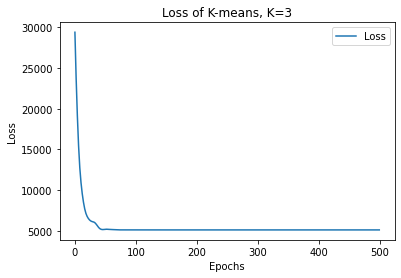

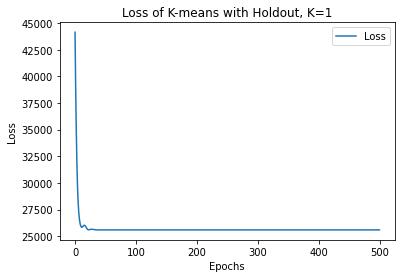

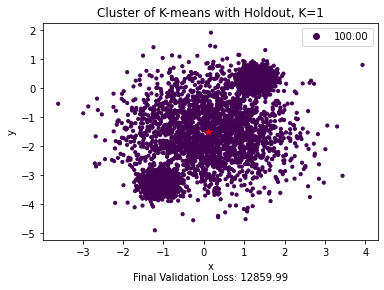

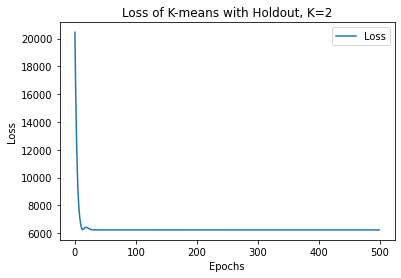

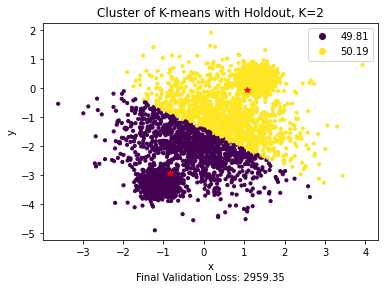

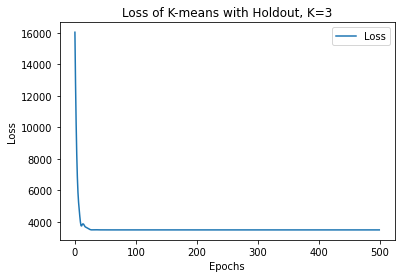

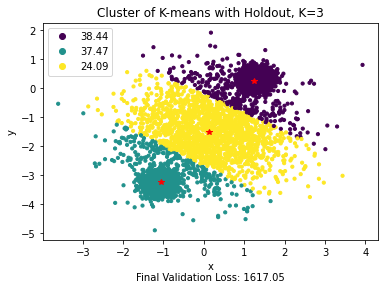

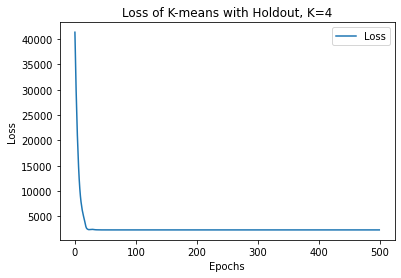

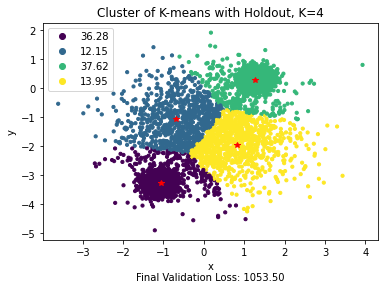

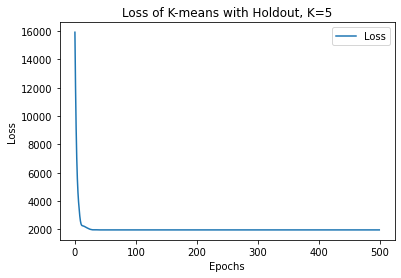

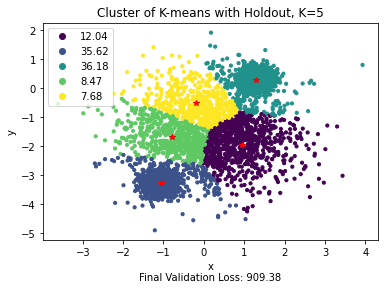

In [7]:
#K-means with K=3
KNN(2, False, 3, 500, True)
#K-means with K=1,2,3,4,5 and hold out 1/3 valid data
KNN(2, True, 1, 500, True)
KNN(2, True, 2, 500, True)
KNN(2, True, 3, 500, True)
KNN(2, True, 4, 500, True)
KNN(2, True, 5, 500, True)

plt.show()

 u =  [[-1.1097803  -3.3057642 ]
 [ 0.10627192 -1.5274153 ]
 [ 1.3027027   0.31479943]]
 sigma =  [0.19774784 0.9917681  0.19709194]
 pi =  [[-1.102687 ]
 [-1.0949941]
 [-1.098171 ]]


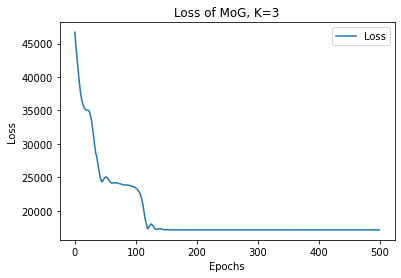

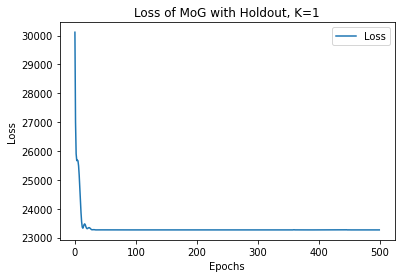

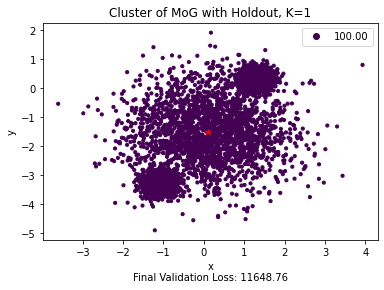

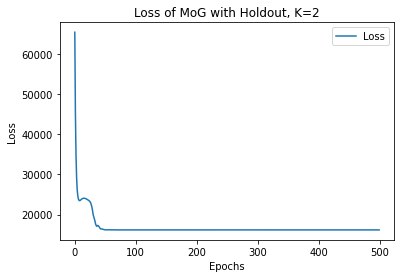

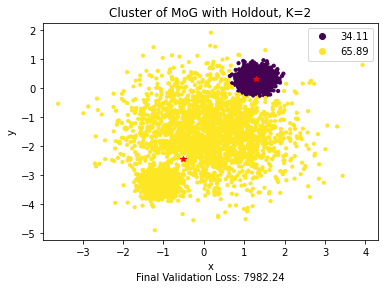

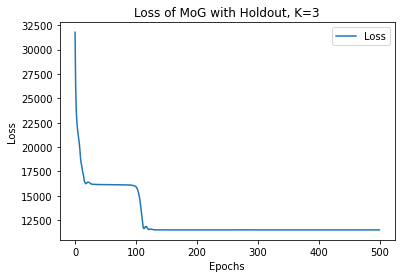

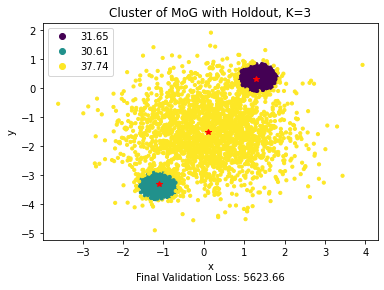

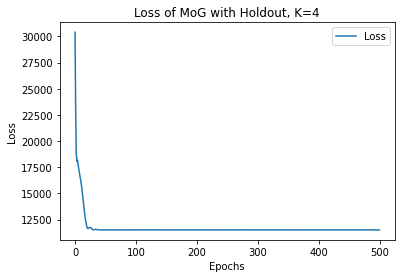

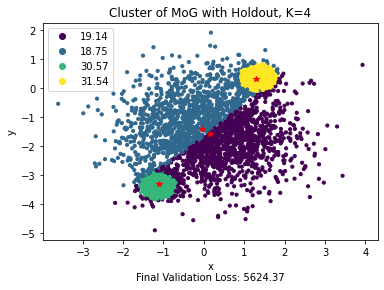

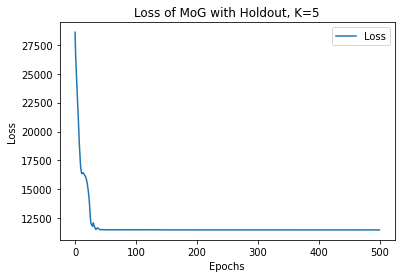

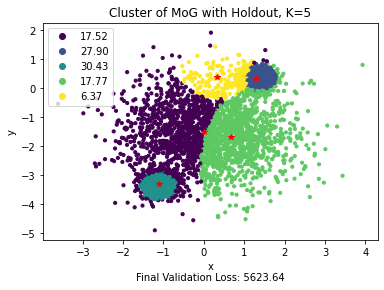

In [18]:
#MoG with K=3
GMM(2, False, 3, 500, True)
#MoG with K=1,2,3,4,5 and hold out 1/3 valid data
GMM(2, True, 1, 500, True)
GMM(2, True, 2, 500, True)
GMM(2, True, 3, 500, True)
GMM(2, True, 4, 500, True)
GMM(2, True, 5, 500, True)

plt.show()


In [16]:
KNN(100, True, 5, 500, False)
KNN(100, True, 10, 500, False)
KNN(100, True, 15, 500, False)
KNN(100, True, 20, 500, False)
KNN(100, True, 30, 500, False)

GMM(100, True, 5, 500, False)
GMM(100, True, 10, 500, False)
GMM(100, True, 15, 500, False)
GMM(100, True, 20, 500, False)
GMM(100, True, 30, 500, False)

K-means Final Validation Loss for K=5: 71713.4765625
K-means Final Validation Loss for K=10: 71712.84375
K-means Final Validation Loss for K=15: 69371.90625
K-means Final Validation Loss for K=20: 70881.59375
K-means Final Validation Loss for K=30: 68658.171875
MoG Final Validation Loss for K=5: 22485.39453125
MoG Final Validation Loss for K=10: 22485.2734375
MoG Final Validation Loss for K=15: 22487.833984375
MoG Final Validation Loss for K=20: 22487.296875
MoG Final Validation Loss for K=30: 22485.228515625
